In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import BatchNormalization, Concatenate,concatenate
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
from keras.layers.convolutional import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sn

Using TensorFlow backend.


## Iperparametri

In [2]:
learning_rate = 0.0003
dropout_rate = 0.6

conv_layers = [25]
hidden_layers = [300, 100]
classes = 7

batch_size = 250
epochs = 150
test_size=0.3

## Ottiene i dati

In [3]:
def balanceData(df):
    all = df.iloc[:, :].values.astype(np.float32)
    A = all[all[:,-1]<70]
    B = all[(all[:,-1]>=70)&(all[:,-1]<=83)]
    C = all[(all[:,-1]>=84)&(all[:,-1]<=98)] 
    D = all[(all[:,-1]>=99)&(all[:,-1]<=113)] 
    E = all[(all[:,-1]>=114)&(all[:,-1]<=128)] 
    F = all[(all[:,-1]>=129)&(all[:,-1]<=143)] 
    G = all[all[:,-1]>143]

    #prende solo una parte dei dati della categoria A
    A = A[0:1750,:]

    #crea nuovamente il dataframe dopo aver pre-elaborato i dati
    data = np.concatenate((A,B,C,D,E,F,G), axis=0)
    np.random.shuffle(data)
    df = pd.DataFrame(data=data)
    return df

#funzione che conta gli elementi per ogni classe
def printCountClass(yr):
    print("A: ",len(yr[yr<70]))
    print("B: ",len(yr[(yr>=70)&(yr<=83)]))
    print("C: ",len(yr[(yr>=84)&(yr<=98)]))
    print("D: ",len(yr[(yr>=99)&(yr<=113)]))
    print("E: ",len(yr[(yr>=114)&(yr<=128)]))
    print("F: ",len(yr[(yr>=129)&(yr<=143)]))
    print("G: ",len(yr[yr>143]))

#ottiene gli output e li trasforma in classi    
def transformToClass(yr):
    yc = []
    for i in range(len(yr)):
        yi = np.zeros(7)
        if (yr[i]<70):                  yi[0] = 1 #A
        if (yr[i]>=70  and yr[i]<=83) : yi[1] = 1 #B
        if (yr[i]>=84  and yr[i]<=98) : yi[2] = 1 #C
        if (yr[i]>=99  and yr[i]<=113): yi[3] = 1 #D
        if (yr[i]>=114 and yr[i]<=128): yi[4] = 1 #E
        if (yr[i]>=129 and yr[i]<=143): yi[5] = 1 #F
        if (yr[i]>143):                 yi[6] = 1 #G
        yc.append(yi)
    yr = np.array(yc)
    return yr

#ottiene gli input ed li divide in dummy variables
def prepareDummiesData(df):
    X = pd.get_dummies(df.iloc[:, 0]).values.astype(np.float32)
    #crea i dummies input
    for i in range(1,48):
        X_dummy = pd.get_dummies(df.iloc[:, i]).values.astype(np.float32)
        X = np.concatenate((X, X_dummy), axis=1)
    #trasforma l'array di numeri in un'immagine con width=24 e height=2
    X = X.reshape(-1, 2, 24*5)
    #trasforma l'immagine in formato accettato dalla convolutional
    X = X.reshape(-1, 24*5, 2, 1)
    
    #prepara l'output
    y = df.iloc[:, -1].values.astype(np.float32)
    printCountClass(y)  
    y = transformToClass(y)

    return X, y

#prepara gli inputs
def prepareData(df):
    #ottiene l'array di input
    X = df.iloc[:, :48].values.astype(np.float32)
    #trasforma l'array di numeri in un'immagine con width=24 e height=2
    X = X.reshape(-1, 2, 24)
    #trasforma l'immagine in formato accettato dalla convolutional
    X = X.reshape(-1, 24, 2, 1).astype(np.float32)/5
    
    #prepara l'output
    y = df.iloc[:, -1].values.astype(np.float32)
    printCountClass(y)  
    y = transformToClass(y)

    return X, y

#print(X_train.reshape(X_train.shape[0], 1, 2, 24))

In [4]:
df = pd.read_csv('patterns10000.csv')
df = balanceData(df)
#X, y = prepareDummiesData(df)
X, y = prepareData(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

A:  1750
B:  1520
C:  1796
D:  1633
E:  676
F:  99
G:  17


## Crea il modello ed effettua il training

In [5]:
def createAndFitModel():
    input = Input((X.shape[1], X.shape[2], X.shape[3])) #input = Input(shape=(24, 2, 1))

    #aggiunge gli strati di convoluzione
    layer = input
    for i in range(len(conv_layers)):
        layer = Conv2D(filters=conv_layers[i], kernel_size=(2, 1), strides=1, use_bias=True)(layer)
        layer = Activation("elu")(layer)
        #layer = Dropout(rate=dropout_rate)(layer)

    layer = Flatten()(layer)

    #aggiunge gli strati nascosti
    for i in range(len(hidden_layers)):
        layer = Dense(units=hidden_layers[i], use_bias=True, init='normal')(layer)
        layer = Activation('elu')(layer)
        layer = Dropout(rate=dropout_rate)(layer)

    layer = Dense(units=classes, use_bias=True, init='normal')(layer)
    output = Activation("softmax")(layer)

    #crea il modello
    model = Model(input, output)

    #compila la rete neurale
    optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    #model.summary()

    #addestra la rete neurale
    history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), shuffle=True, verbose=1)

    return model, history
    
def printLoss():
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def printEvaluate():
    print("Evaluate: ", model.evaluate(X_test, y_test, verbose=0))
    
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    y_class = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_class, y_pred)
    df_cm = pd.DataFrame(cm, 
                         index = [i for i in range(cm.shape[0])],
                         columns = [i for i in range(cm.shape[1])])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

## Effettua il training e stampa le perdite

In [6]:
model, history = createAndFitModel()

C:\Users\Utente\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=300, use_bias=True, kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\Users\Utente\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=100, use_bias=True, kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\Users\Utente\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=7, use_bias=True, kernel_initializer="normal")`


Train on 5243 samples, validate on 2248 samples
Epoch 1/150
5243/5243 [==============================] - 1s 212us/step - loss: 0.3788 - acc: 0.8574 - val_loss: 0.3560 - val_acc: 0.8571
Epoch 2/150
5243/5243 [==============================] - 1s 154us/step - loss: 0.3629 - acc: 0.8575 - val_loss: 0.3501 - val_acc: 0.8571
Epoch 3/150
5243/5243 [==============================] - 1s 149us/step - loss: 0.3549 - acc: 0.8576 - val_loss: 0.3417 - val_acc: 0.8577
Epoch 4/150
5243/5243 [==============================] - 1s 161us/step - loss: 0.3438 - acc: 0.8601 - val_loss: 0.3323 - val_acc: 0.8613
Epoch 5/150
5243/5243 [==============================] - 1s 165us/step - loss: 0.3385 - acc: 0.8612 - val_loss: 0.3262 - val_acc: 0.8627
Epoch 6/150
5243/5243 [==============================] - 1s 139us/step - loss: 0.3315 - acc: 0.8633 - val_loss: 0.3223 - val_acc: 0.8625
Epoch 7/150
5243/5243 [==============================] - 1s 160us/step - loss: 0.3294 - acc: 0.8624 - val_loss: 0.3209 - val_acc: 

Epoch 60/150
5243/5243 [==============================] - 1s 120us/step - loss: 0.2074 - acc: 0.9151 - val_loss: 0.1880 - val_acc: 0.9319
Epoch 61/150
5243/5243 [==============================] - 1s 124us/step - loss: 0.2055 - acc: 0.9137 - val_loss: 0.1876 - val_acc: 0.9284
Epoch 62/150
5243/5243 [==============================] - 1s 136us/step - loss: 0.2036 - acc: 0.9150 - val_loss: 0.1874 - val_acc: 0.9344
Epoch 63/150
5243/5243 [==============================] - 1s 125us/step - loss: 0.2037 - acc: 0.9175 - val_loss: 0.1846 - val_acc: 0.9342
Epoch 64/150
5243/5243 [==============================] - 1s 128us/step - loss: 0.2021 - acc: 0.9167 - val_loss: 0.1831 - val_acc: 0.9295
Epoch 65/150
5243/5243 [==============================] - 1s 120us/step - loss: 0.1995 - acc: 0.9192 - val_loss: 0.1799 - val_acc: 0.9326
Epoch 66/150
5243/5243 [==============================] - 1s 135us/step - loss: 0.2004 - acc: 0.9178 - val_loss: 0.1790 - val_acc: 0.9394
Epoch 67/150
5243/5243 [==========

5243/5243 [==============================] - 1s 134us/step - loss: 0.1635 - acc: 0.9341 - val_loss: 0.1452 - val_acc: 0.9459
Epoch 120/150
5243/5243 [==============================] - 1s 130us/step - loss: 0.1653 - acc: 0.9343 - val_loss: 0.1411 - val_acc: 0.9497
Epoch 121/150
5243/5243 [==============================] - 1s 133us/step - loss: 0.1658 - acc: 0.9332 - val_loss: 0.1413 - val_acc: 0.9490
Epoch 122/150
5243/5243 [==============================] - 1s 128us/step - loss: 0.1620 - acc: 0.9359 - val_loss: 0.1446 - val_acc: 0.9478
Epoch 123/150
5243/5243 [==============================] - 1s 133us/step - loss: 0.1617 - acc: 0.9341 - val_loss: 0.1422 - val_acc: 0.9477
Epoch 124/150
5243/5243 [==============================] - 1s 126us/step - loss: 0.1630 - acc: 0.9335 - val_loss: 0.1407 - val_acc: 0.9450
Epoch 125/150
5243/5243 [==============================] - 1s 130us/step - loss: 0.1650 - acc: 0.9332 - val_loss: 0.1404 - val_acc: 0.9489
Epoch 126/150
5243/5243 [================

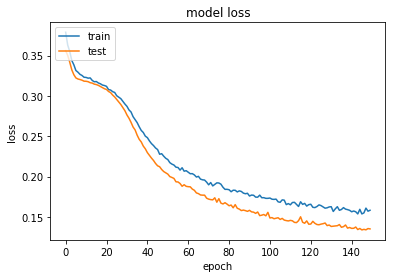

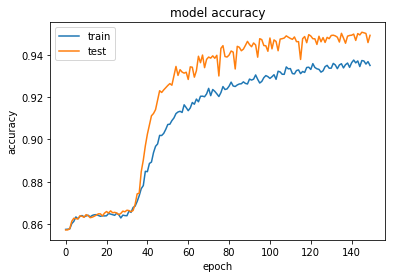

Evaluate:  [0.13526707956587292, 0.949351828293444]


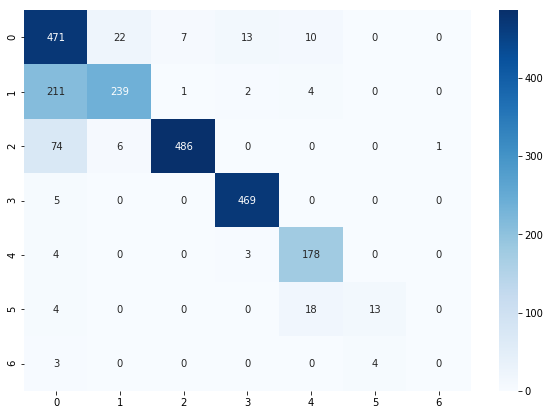

In [9]:
printLoss()
printEvaluate()